# Imports

In [1]:
from modules.data import data_loader, data_splitter, data_reader
from modules.models import arima, lag_llama, autoregressor
from modules.evaluation import evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from modules.experiment.experiment import run_experiment
from modules.data.tscv import create_tscv_dataset
from modules.experiment.tscv import get_tscv_results, mean_directional_accuracy, get_summary


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import islice
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Parameters

In [2]:
PREDICTION_LENGTH = 10 # currentlz only works for PREDICTION_LENGTH > 1
FREQUENCY = "daily" # currently we only have dailz frequency
TYPE_OF_DATA = "stock" # currently we only have stock prices saved
MODELS = ["arima", "llama"] # currentlz works onlz for these two
FOLDS = 10 # for TSCV
CONTEXT_LENGTH = 64

#START_DATE = 
#END_DATE
# want to add
#TRAIN_PERIOD = # context lenghts. Should take a look into this
#TRAIN_SIZE = 




# Notes

 - autoregressor
 - mean directional accuracy
 - ask
 - for each time-series create a whole dataframe for TSCV
  - problem with this is with time horizon that is >1 
  - prediction horizon is only for that value in the future

# TO DO

 - create the TSCV experiment. It needs to create a table. Metrics for each fold
 - lit review
 - content for the presentation by monday!!
 - review data leakage risk
 - writing of the dissertation
 - autoregressor
 - MDA metric
 - frequency

 Writing
 - lit review
 - lit reading

# Loading the data

In [3]:
data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY)
# this is just in case there are more CSVs of the same type and frequency, the data should be the first in the list
if len(data) > 1:
    data = data[0]

simple_data = data_loader.get_simle_data()

[*********************100%%**********************]  1 of 1 completed


# Prepare the data

In [4]:
# pass full data at maximum granularity and produce according to frequency parameter

In [6]:
tscv_data = create_tscv_dataset(data = simple_data, context_length=CONTEXT_LENGTH, n_folds=FOLDS, prediction_horizon=PREDICTION_LENGTH, max_folds=False)

# Models

In [7]:
# arima


In [8]:
# lag llama

# Run regular experiment

In [ ]:
results = run_experiment(data = data, prediction_length = PREDICTION_LENGTH)

# Evaluation

In [ ]:
results

# Run TSCV experiment

look up tzpes of TSCV

In [10]:
tscv_results, prediction = run_experiment(data=tscv_data, tscv=True)

y0 done  1
------------
y1 done  2
------------
y2 done  3
------------
y3 done  4
------------
y4 done  5
------------
y5 done  6
------------
y6 done  7
------------
y7 done  8
------------
y8 done  9
------------
y9 done  10
------------


In [11]:
tscv_results

{'r2': {'arima': -0.8036159605688358, 'llama': -4.690321882253741},
 'mse': {'arima': 9.014638013311012, 'llama': 28.440750730306206},
 'mae': {'arima': 2.712121007999187, 'llama': 4.178632465124013},
 'rmse': {'arima': 3.0024386776936867, 'llama': 5.332987036390226}}

# SKLearn TSCV

In [3]:
simple_data = data_loader.get_simle_data()

[*********************100%%**********************]  1 of 1 completed


In [4]:
# sklearn tscv object
tscv = TimeSeriesSplit(n_splits=FOLDS, test_size=PREDICTION_LENGTH)


expanding or rolling window?

suggestion: do rolling window!

In [5]:
# extracting the time-series data from original data
series = simple_data["y"]

- put metrics in dataframe. one for arima, one for lag llama  DONE
- each column metric, each row is a fold  DONE
- create wrapper function get_metrics(predicted, actual) returns pd.DataFrame of description above
- by end of day have a table   DONE
- agenda of the presentation by 12   DONE
- implement autoregressor forecast t1 = t0     DONE
- implement frequency experimentation          DONE
- start training date global parameter

In [ ]:
# initializing the list of models, metrics and emptz result dict
models=["arima", "llama"]
metrics=["r2", "mse", "mae", "rmse", "mda"]
results = {metric: {model: {f"fold_{i}": [] for i in range(FOLDS)} for model in models} for metric in metrics}

arima_results = pd.DataFrame(columns=metrics)
llama_results = pd.DataFrame(columns= metrics)
autoregressor_results = pd.DataFrame(columns=metrics)




i = 0
# iterating over all the folds
for train_index, test_index in tscv.split(series):
    # subsetting the original data according to train/test split
    train = simple_data.iloc[train_index]
    valid = list(simple_data.iloc[test_index]["y"])

    # for my testing purposes
    #print(train["y"])
    #print(train["y"].iloc[-1])


    # inputting data into the models
    arima_model = arima.get_autoarima(train)
    autoarima_predictions = arima.autoarima_predictions(arima_model, PREDICTION_LENGTH)
    lag_llama_predictions, tss = lag_llama.get_lam_llama_forecast(train, PREDICTION_LENGTH, context_length=CONTEXT_LENGTH)
    lag_llama_predictions = list(lag_llama_predictions[0].samples.mean(axis = 0))
    autoregressor_predictions = autoregressor.get_autoregressor_prediction(train, PREDICTION_LENGTH)

    """
    print(i)
    print("----------")
    print(len(lag_llama_predictions))
    print("--------------")
    print(len(valid))
    print("---------------")
    print(PREDICTION_LENGTH)
    print("------------------")
    print(r2_score(valid, lag_llama_predictions))
    """

    # for my own testing purposes
    """
    print(autoarima_predictions)
    print(lag_llama_predictions)
    print(valid)
    """

    # recording the metrics
    """
    results["r2"]["arima"][f"fold_{i}"].append(r2_score(valid, autoarima_predictions))
    results["mse"]["arima"][f"fold_{i}"].append(mean_squared_error(valid, autoarima_predictions))
    results["mae"]["arima"][f"fold_{i}"].append(mean_absolute_error(valid, autoarima_predictions))
    results["rmse"]["arima"][f"fold_{i}"].append(np.sqrt(mean_squared_error(valid, autoarima_predictions)))

    results["r2"]["llama"][f"fold_{i}"].append(r2_score(valid, lag_llama_predictions))
    results["mse"]["llama"][f"fold_{i}"].append(mean_squared_error(valid, lag_llama_predictions))
    results["mae"]["llama"][f"fold_{i}"].append(mean_absolute_error(valid, lag_llama_predictions))
    results["rmse"]["llama"][f"fold_{i}"].append(np.sqrt(mean_squared_error(valid, lag_llama_predictions)))
    """

    arima_metrics = [r2_score(valid, autoarima_predictions), 
               mean_squared_error(valid, autoarima_predictions), 
               mean_absolute_error(valid, autoarima_predictions),
               np.sqrt(mean_squared_error(valid, autoarima_predictions)),
               mean_directional_accuracy(valid, autoarima_predictions, train["y"].iloc[-1])]
    
    llama_metrics = [r2_score(valid, lag_llama_predictions), 
               mean_squared_error(valid, lag_llama_predictions), 
               mean_absolute_error(valid, lag_llama_predictions),
               np.sqrt(mean_squared_error(valid, lag_llama_predictions)),
               mean_directional_accuracy(valid, lag_llama_predictions, train["y"].iloc[-1])]
    
    autoregressor_metrics = [r2_score(valid, autoregressor_predictions), 
               mean_squared_error(valid, autoregressor_predictions), 
               mean_absolute_error(valid, autoregressor_predictions),
               np.sqrt(mean_squared_error(valid, autoregressor_predictions)),
               mean_directional_accuracy(valid, autoregressor_predictions, train["y"].iloc[-1])]

    arima_results = pd.concat([arima_results, pd.DataFrame([arima_metrics], columns=metrics)], ignore_index=True)
    llama_results = pd.concat([llama_results, pd.DataFrame([llama_metrics], columns=metrics)], ignore_index=True)
    autoregressor_results = pd.concat([autoregressor_results, pd.DataFrame([autoregressor_metrics], columns=metrics)], ignore_index=True)


    i += 1

In [18]:
arima_results

,r2,mse,mae,rmse,mda
0,-10.146053,33.415565,5.512960,5.780620,0.2
1,-1.069529,56.237796,5.979982,7.499186,0.8
2,-0.021127,5.389042,1.626925,2.321431,0.4
3,-0.130501,2.120663,1.296481,1.456249,0.6
4,0.009028,14.090569,3.312309,3.753741,0.5
5,-1.962910,94.272351,7.710001,9.709395,0.4
6,-2.799649,39.613602,5.353981,6.293934,0.1
7,-0.137856,7.045263,2.276720,2.654291,0.9
8,-1.762008,200.092281,12.148269,14.145398,0.4
9,-0.884450,68.486433,6.201827,8.275653,0.1


In [19]:
arima_summary = pd.DataFrame({
    'r2': [arima_results['r2'].mean(), arima_results['r2'].median(), arima_results['r2'].std()],
    'mse': [arima_results['mse'].mean(), arima_results['mse'].median(), arima_results['mse'].std()],
    'mae': [arima_results['mae'].mean(), arima_results['mae'].median(), arima_results['mae'].std()],
    'rmse': [arima_results['rmse'].mean(), arima_results['rmse'].median(), arima_results['rmse'].std()],
    'mda': [arima_results['mda'].mean(), arima_results['mda'].median(), arima_results['mda'].std()]
}, index=['mean', 'median', 'std'])

In [20]:
arima_summary

,r2,mse,mae,rmse,mda
mean,-1.890506,52.076356,5.141945,6.188990,0.440000
median,-0.976990,36.514584,5.433470,6.037277,0.400000
std,3.054336,60.208310,3.272644,3.911914,0.271621


In [21]:
llama_results

,r2,mse,mae,rmse,mda
0,-11.283636,36.826008,5.202384,6.068444,0.6
1,-6.114432,193.328999,12.492389,13.904280,0.3
2,-27.709435,151.515247,12.034618,12.309153,0.5
3,-117.051050,221.447375,14.750225,14.881108,0.5
4,-10.914719,169.414716,12.395660,13.015941,0.5
5,-2.360813,106.932600,9.050172,10.340822,0.6
6,-2.001025,31.287475,4.966641,5.593521,0.6
7,-10.787917,72.987215,7.751465,8.543256,0.4
8,-7.082025,585.498344,22.845116,24.197073,0.5
9,-26.135169,986.171396,30.635747,31.403366,0.4


In [22]:
llama_summary = pd.DataFrame({
    'r2': [llama_results['r2'].mean(), llama_results['r2'].median(), llama_results['r2'].std()],
    'mse': [llama_results['mse'].mean(), llama_results['mse'].median(), llama_results['mse'].std()],
    'mae': [llama_results['mae'].mean(), llama_results['mae'].median(), llama_results['mae'].std()],
    'rmse': [llama_results['rmse'].mean(), llama_results['rmse'].median(), llama_results['rmse'].std()],
    'mda': [llama_results['mda'].mean(), llama_results['mda'].median(), llama_results['mda'].std()]
}, index=['mean', 'median', 'std'])

In [23]:
llama_summary

,r2,mse,mae,rmse,mda
mean,-22.144022,255.540937,13.212442,14.025696,0.490000
median,-10.851318,160.464981,12.215139,12.662547,0.500000
std,34.493446,301.754252,8.031871,8.084332,0.099443


In [25]:
autoregressor_results

,r2,mse,mae,rmse,mda
0,-9.748225,32.222889,5.406007,5.676521,0.0
1,-1.338956,63.559268,6.378003,7.972407,0.0
2,-0.056281,5.574567,1.645000,2.361052,0.0
3,-0.427978,2.678689,1.514003,1.636670,0.0
4,-0.004325,14.280447,3.302000,3.778948,0.0
5,-1.668451,84.903390,7.286008,9.214304,0.0
6,-2.683164,38.399180,5.289006,6.196707,0.0
7,-0.095014,6.779998,2.207004,2.603843,0.0
8,-1.774466,200.994832,12.166003,14.177265,0.0
9,-0.709524,62.129100,5.946002,7.882201,0.0


In [24]:
llama_summary - arima_summary

,r2,mse,mae,rmse,mda
mean,-20.253517,203.464581,8.070496,7.836706,0.050000
median,-9.874328,123.950398,6.781669,6.625270,0.100000
std,31.439111,241.545942,4.759227,4.172418,-0.172178


- find a way to show difference between tables       DONE??
- different tables for different statistics !!! (mean, median, std)    DONE
- visualize (plot the results) PLOTLY   DONE
- a plot for each fold
- implement frequency for simple data
- enforce try
- when running tscv print time for every fold, train size
- start adding more models - fine tuned lag llama first, prophet, others
- do we want any more metrics? Are we missing anything in order to be able to say which model is better
- CLEAN UP THE CODE

expanding or rolling window? - an idea for experiment
Try using rolling for now

suggestion: do rolling window!


MAIN POINTS: VISUALIZATION, RESULTS REPRESENTATION, 

In [4]:
r, p, a = get_tscv_results(simple_data, PREDICTION_LENGTH, CONTEXT_LENGTH, FOLDS)

c:\Users\topco\Dokumenti\MSc Banking and Digital Finance UCL\Modules\Dissertation\MSc_dissertation\modules\experiment\tscv.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arima_results = pd.concat([arima_results, pd.DataFrame([arima_metrics], columns=metrics)], ignore_index=True)
c:\Users\topco\Dokumenti\MSc Banking and Digital Finance UCL\Modules\Dissertation\MSc_dissertation\modules\experiment\tscv.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  llama_results = pd.concat([llama_res

In [10]:
s = [get_summary(r[i]) for i in range(len(r))]

In [11]:
s[1]

,r2,mse,mae,rmse,mda
mean,-20.618913,280.453813,13.796589,14.561009,0.470000
median,-11.887980,199.958631,13.588897,14.140388,0.500000
std,24.743780,338.631817,8.565313,8.719762,0.133749


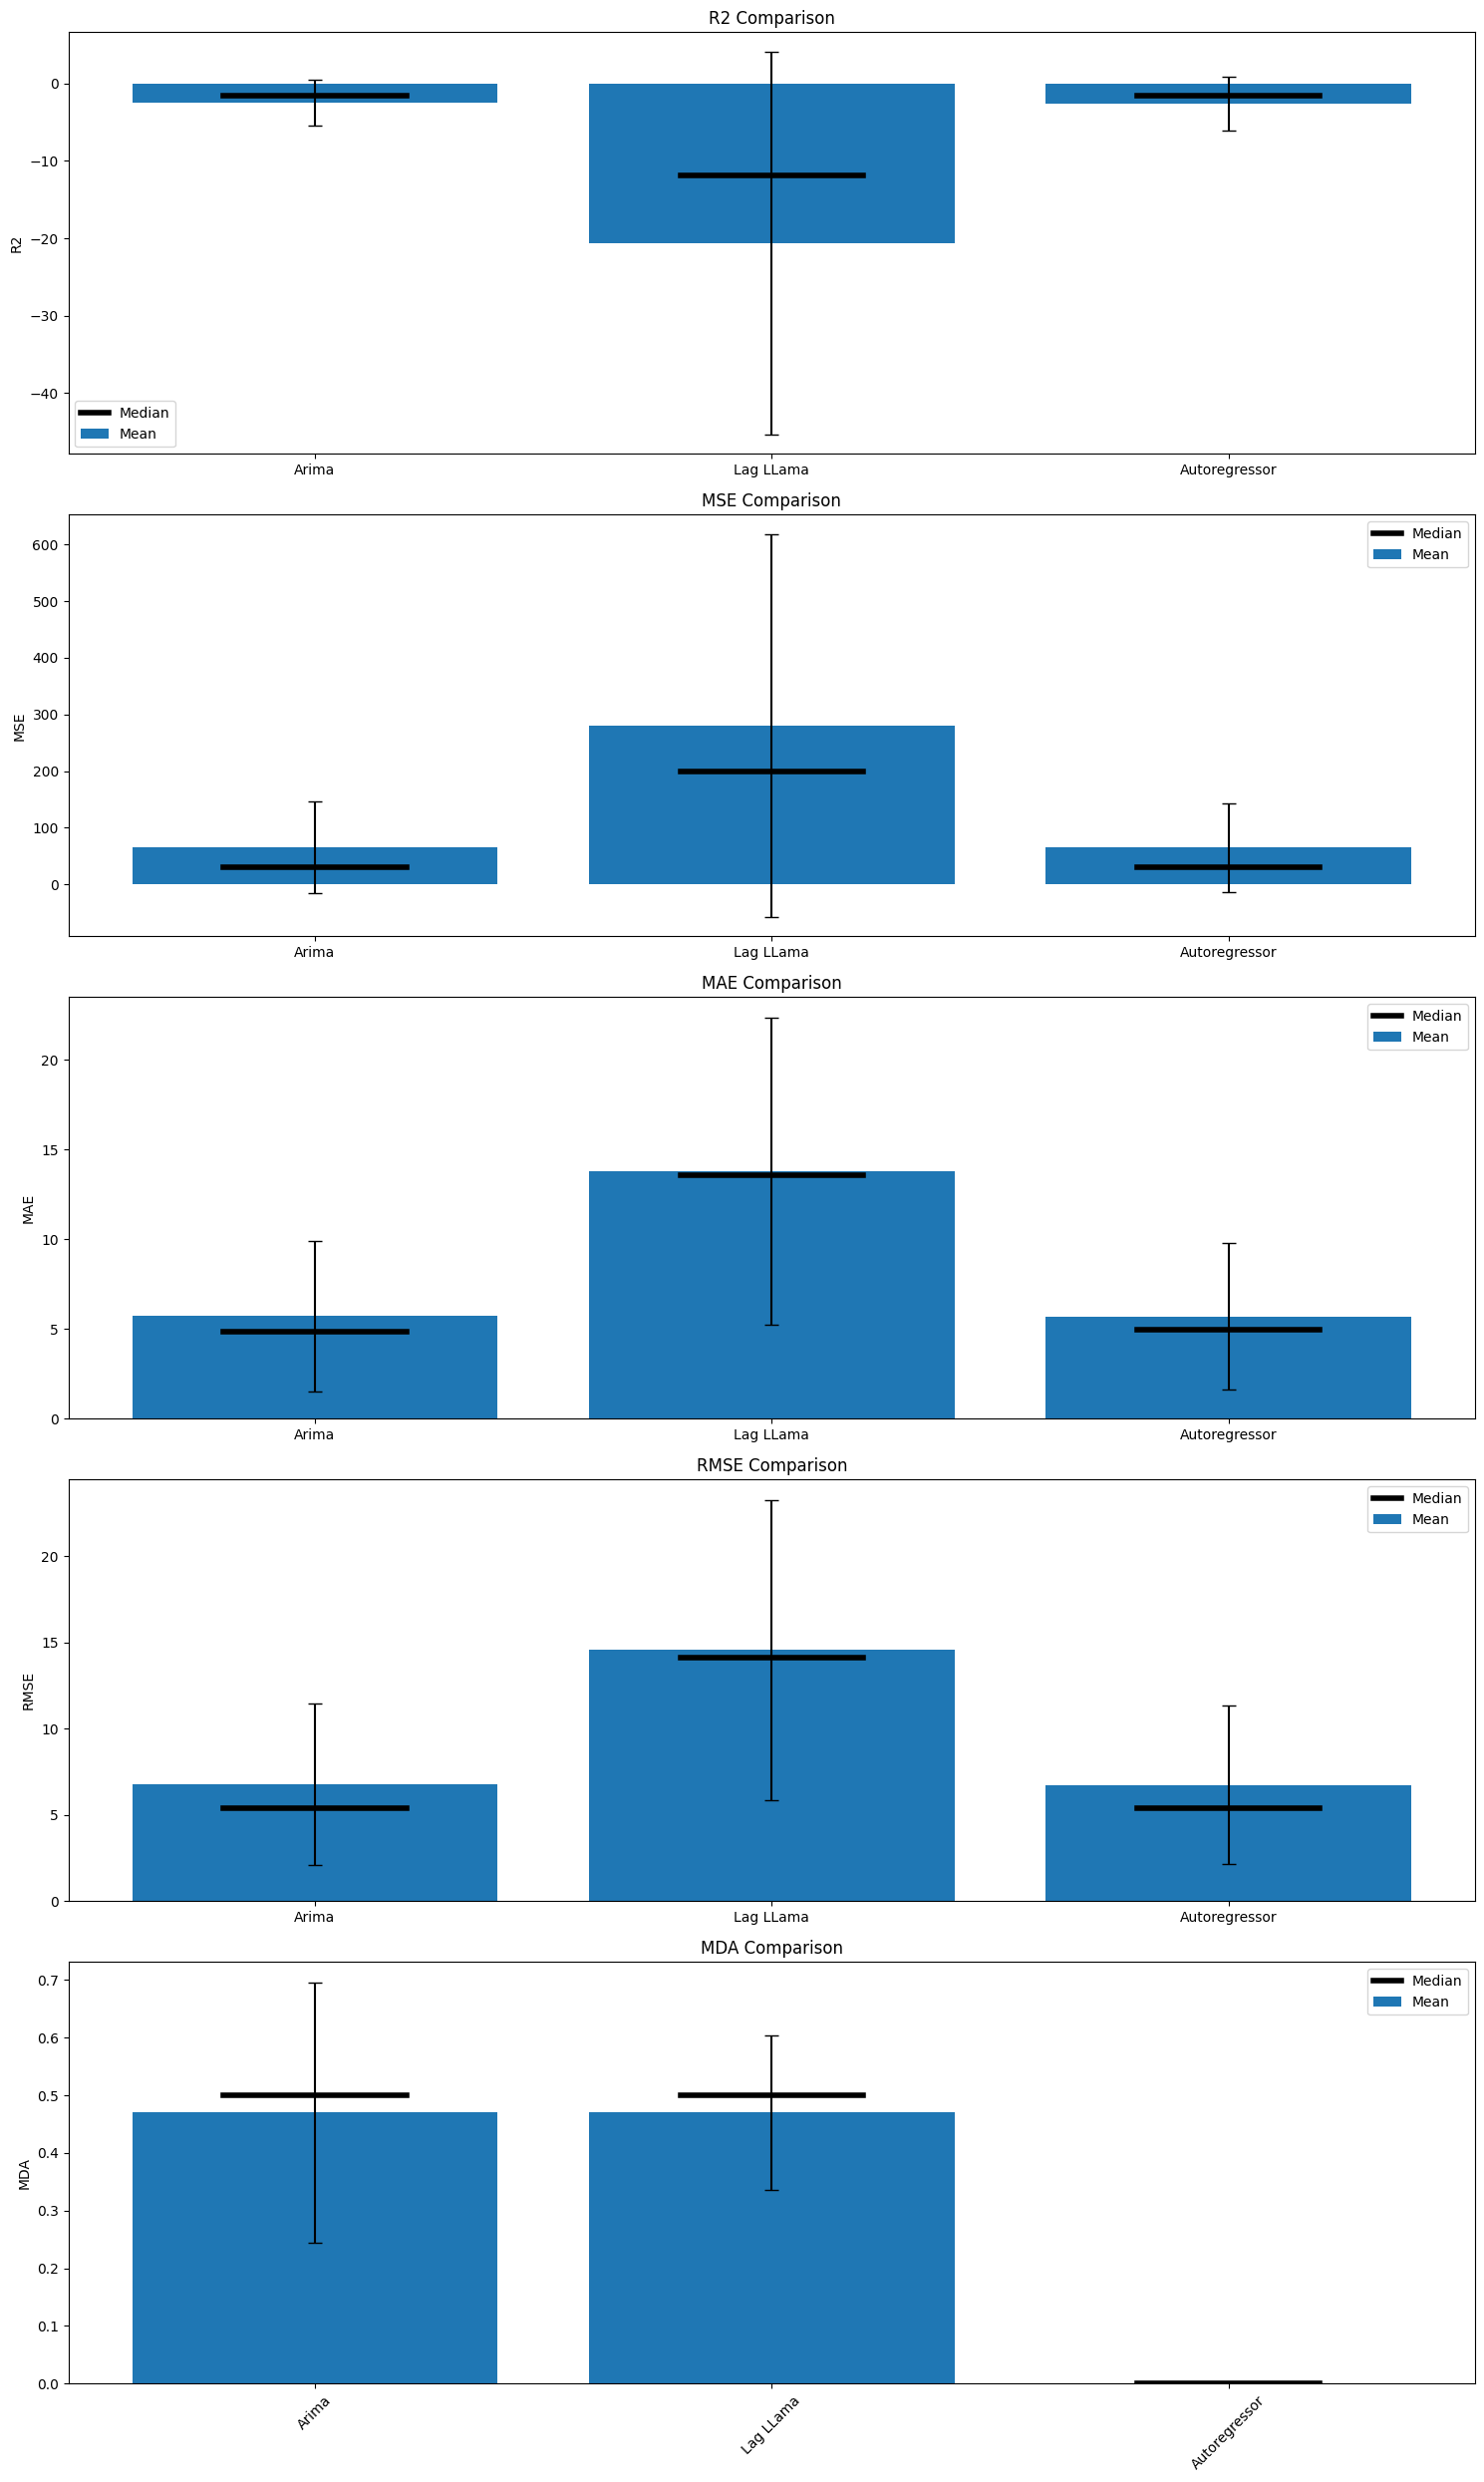

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'r' is your list of dataframes
# Sample structure for 'r'
# r = [df1, df2, df3, ...]

# Model names
model_names = ['Arima', 'Lag LLama', 'Autoregressor']

# Extracting summary statistics for each model
summary_stats = {'model': [], 'metric': [], 'mean': [], 'median': [], 'std': []}
metrics = ['r2', 'mse', 'mae', 'rmse', 'mda']

for i, df in enumerate(s):
    for metric in metrics:
        summary_stats['model'].append(model_names[i])
        summary_stats['metric'].append(metric)
        summary_stats['mean'].append(df.loc['mean', metric])
        summary_stats['median'].append(df.loc['median', metric])
        summary_stats['std'].append(df.loc['std', metric])

summary_df = pd.DataFrame(summary_stats)

# Plotting
fig, axes = plt.subplots(len(metrics), 1, figsize=(15, len(metrics) * 5))

for idx, metric in enumerate(metrics):
    metric_data = summary_df[summary_df['metric'] == metric]
    
    # Plotting mean with error bars representing standard deviation
    axes[idx].bar(metric_data['model'], metric_data['mean'], yerr=metric_data['std'], capsize=5, label='Mean')
    
    # Plotting median as a thick black line
    for i, model in enumerate(metric_data['model']):
        median_value = metric_data[metric_data['model'] == model]['median'].values[0]
        axes[idx].plot([i - 0.2, i + 0.2], [median_value, median_value], color='black', linewidth=4, label='Median' if i == 0 else "")

    axes[idx].set_title(f'{metric.upper()} Comparison')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# Assuming 'r' is your list of dataframes
# Sample structure for 'r'
# r = [df1, df2, df3, ...]

# Model names
model_names = ['Arima', 'Lag LLama', 'Autoregressor']

# Extracting summary statistics for each model
summary_stats = {'model': [], 'metric': [], 'mean': [], 'median': [], 'std': []}
metrics = ['r2', 'mse', 'mae', 'rmse', 'mda']

for i, df in enumerate(s):
    for metric in metrics:
        summary_stats['model'].append(model_names[i])
        summary_stats['metric'].append(metric)
        summary_stats['mean'].append(df.loc['mean', metric])
        summary_stats['median'].append(df.loc['median', metric])
        summary_stats['std'].append(df.loc['std', metric])

summary_df = pd.DataFrame(summary_stats)

# Plotting
fig = go.Figure()

for model in model_names:
    for metric in metrics:
        # mse is too large for every model, so it hinders visualization
        if metric == "mse":
            continue

        metric_data = summary_df[(summary_df['model'] == model) & (summary_df['metric'] == metric)]
        fig.add_trace(go.Bar(
            x=[metric],
            y=metric_data['mean'],
            error_y=dict(type='data', array=metric_data['std'], visible=True),
            name=f'{model} Mean of {metric.upper()}',
            hovertext=f'{model}',
            hoverinfo='text+y',
            legendgroup=model
        ))

        # Adding median as a thick black line
        fig.add_trace(go.Scatter(
            x=[metric],
            y=metric_data['median'],
            mode='markers',
            marker=dict(color='black', size=10, symbol='line-ns-open'),
            name=f'{model} Median of {metric.upper()}',
            hoverinfo='skip',
            legendgroup=model,
            showlegend=False
        ))

# Updating layout
fig.update_layout(
    title='Model Metrics Comparison',
    barmode='group',
    xaxis=dict(title='Metrics'),
    yaxis=dict(title='Metric Value'),
    legend=dict(orientation='h', y=-0.2),
    height=800,
    width=1200
)

fig.show()


In [32]:
# Model names
model_names = ['Arima', 'Lag LLama', 'Autoregressor']

# Extracting summary statistics for each model
summary_stats = {'model': [], 'metric': [], 'mean': [], 'median': [], 'std': []}
metrics = ['r2', 'mse', 'mae', 'rmse', 'mda']

for i, df in enumerate(s):
    for metric in metrics:
        summary_stats['model'].append(model_names[i])
        summary_stats['metric'].append(metric)
        summary_stats['mean'].append(df.loc['mean', metric])
        summary_stats['median'].append(df.loc['median', metric])
        summary_stats['std'].append(df.loc['std', metric])

summary_df = pd.DataFrame(summary_stats)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Model Metrics Comparison"),
    html.Div([
        html.Label('Select Metrics:'),
        dcc.Dropdown(
            id='metric-selector',
            options=[{'label': metric.upper(), 'value': metric} for metric in metrics],
            value=metrics,
            multi=True
        ),
        html.Label('Select Models:'),
        dcc.Dropdown(
            id='model-selector',
            options=[{'label': model, 'value': model} for model in model_names],
            value=model_names,
            multi=True
        )
    ], style={'width': '50%', 'display': 'inline-block'}),
    dcc.Graph(id='metric-graph')
])

@app.callback(
    Output('metric-graph', 'figure'),
    [Input('metric-selector', 'value'),
     Input('model-selector', 'value')]
)
def update_graph(selected_metrics, selected_models):
    fig = go.Figure()

    model_color_map = {
        'Arima': 'red',
        'Lag LLama': 'green',
        'Autoregressor': 'blue'
    }

    for metric in selected_metrics:
        for model in selected_models:
            metric_data = summary_df[(summary_df['model'] == model) & (summary_df['metric'] == metric)]
            color = model_color_map[model]

            fig.add_trace(go.Bar(
                x=[metric.upper()],
                y=metric_data['mean'],
                error_y=dict(type='data', array=metric_data['std'], visible=True),
                name=f'{model} Mean',
                hovertext=f'{model} - {metric.upper()}',
                hoverinfo='text+y',
                legendgroup=model,
                marker_color=color,
                offsetgroup=model
            ))

            # Adding median as a thick black line
            fig.add_trace(go.Scatter(
                x=[metric.upper()],
                y=metric_data['median'],
                mode='markers',
                marker=dict(color='black', size=10, symbol='line-ns-open'),
                name=f'{model} Median',
                hoverinfo='skip',
                legendgroup=model,
                showlegend=False,
                offsetgroup=model
            ))

    # Updating layout
    fig.update_layout(
        title='Model Metrics Comparison',
        barmode='group',
        xaxis=dict(title='Metrics', categoryorder='array', categoryarray=[metric.upper() for metric in selected_metrics]),
        yaxis=dict(title='Metric Value'),
        legend=dict(orientation='h', y=-0.2),
        height=800,
        width=1200
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [10]:
def visualize_predictions(p, a):
    """
    Visualizes the predictions and actual values of the time series.

    Parameters:
    p (list of pd.DataFrame): List containing the dataframes for the models.
    a (pd.DataFrame): DataFrame containing the actual values.

    Returns:
    fig: Plotly figure object.
    """
    model_mapping = {
        "Arima": p[0],
        "Lag llama": p[1],
        "Autoregressor": p[2]
    }

    models = list(model_mapping.keys())
    folds = list(range(len(a)))

    fig = make_subplots(rows=1, cols=1)
    
    # Add traces for all models and folds, but make them invisible initially
    for model in models:
        for fold in folds:
            predicted_values = model_mapping[model].iloc[fold].values
            fig.add_trace(go.Scatter(x=list(range(1, len(predicted_values)+1)), 
                                     y=predicted_values, 
                                     mode='lines+markers', 
                                     name=f'{model} Fold {fold}',
                                     visible=False))
            
    for fold in folds:
        actual_values = a.iloc[fold].values
        fig.add_trace(go.Scatter(x=list(range(1, len(actual_values)+1)), 
                                 y=actual_values, 
                                 mode='lines+markers', 
                                 name=f'Actual Fold {fold}',
                                 visible=False))

    # Create buttons for folds
    fold_buttons = []
    for fold in folds:
        visibility = []
        for trace in fig.data:
            if f'Fold {fold}' in trace.name:
                visibility.append(True)
            else:
                visibility.append(False)
        button = dict(
            label=f'Fold {fold}',
            method='update',
            args=[{'visible': visibility},
                  {'title': f'Predictions for Fold {fold}'}]
        )
        fold_buttons.append(button)

    fig.update_layout(
        updatemenus=[
            dict(active=0,
                 buttons=fold_buttons,
                 direction='down',
                 showactive=True,
                 x=0.17,
                 xanchor="left",
                 y=1.15,
                 yanchor="top")
        ],
        title=f'Predictions',
        height=600,
        width=800
    )
    
    # Initially show the first fold
    fig.update_traces(visible=True, selector=dict(name=f'Arima Fold 0'))
    fig.update_traces(visible=True, selector=dict(name=f'Lag llama Fold 0'))
    fig.update_traces(visible=True, selector=dict(name=f'Autoregressor Fold 0'))
    fig.update_traces(visible=True, selector=dict(name=f'Actual Fold 0'))

    return fig

# Example usage
fig = visualize_predictions(p, a)
fig.show()
